In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# if torch.backends.mps.is_available():
#     device = torch.device("mps")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
# else:
device = torch.device("cpu")

print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cpu


In [4]:
# Read in a image from torchvision
import torchvision
img = torchvision.io.read_image("image.jpg")
print(img.shape)


torch.Size([3, 4000, 6000])


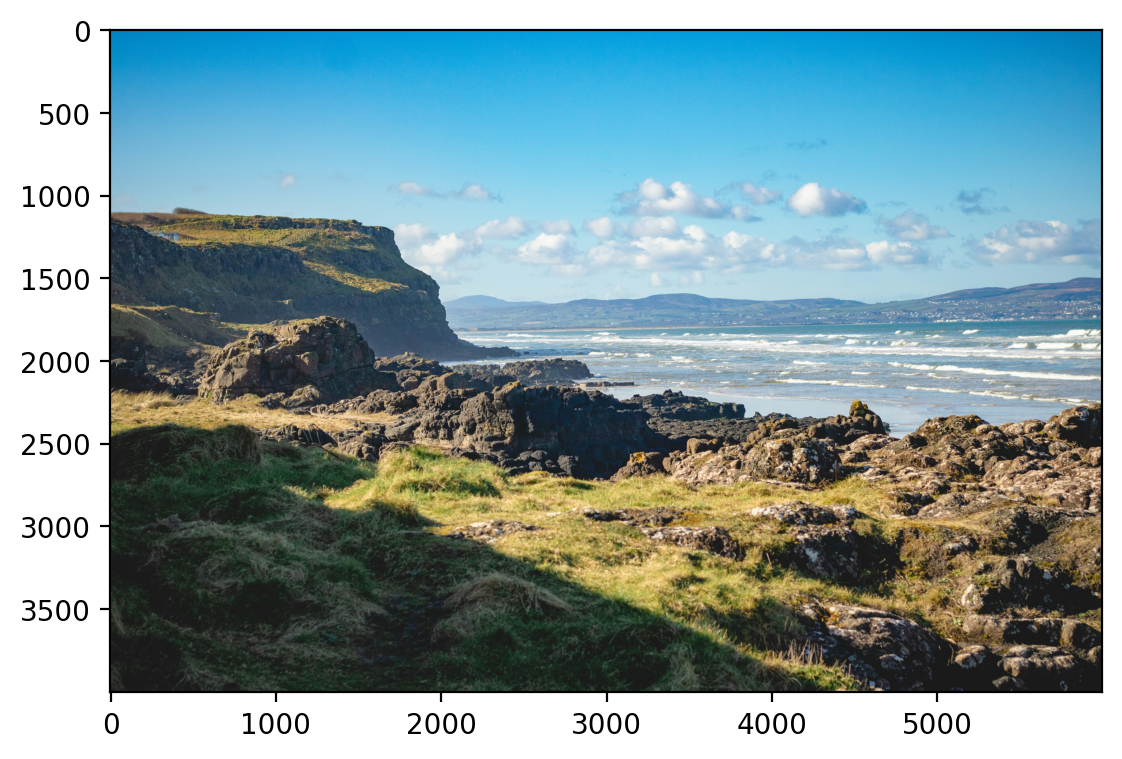

In [5]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [6]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [7]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to('cpu')
img_scaled.shape

torch.Size([3, 4000, 6000])

torch.Size([3, 300, 300])


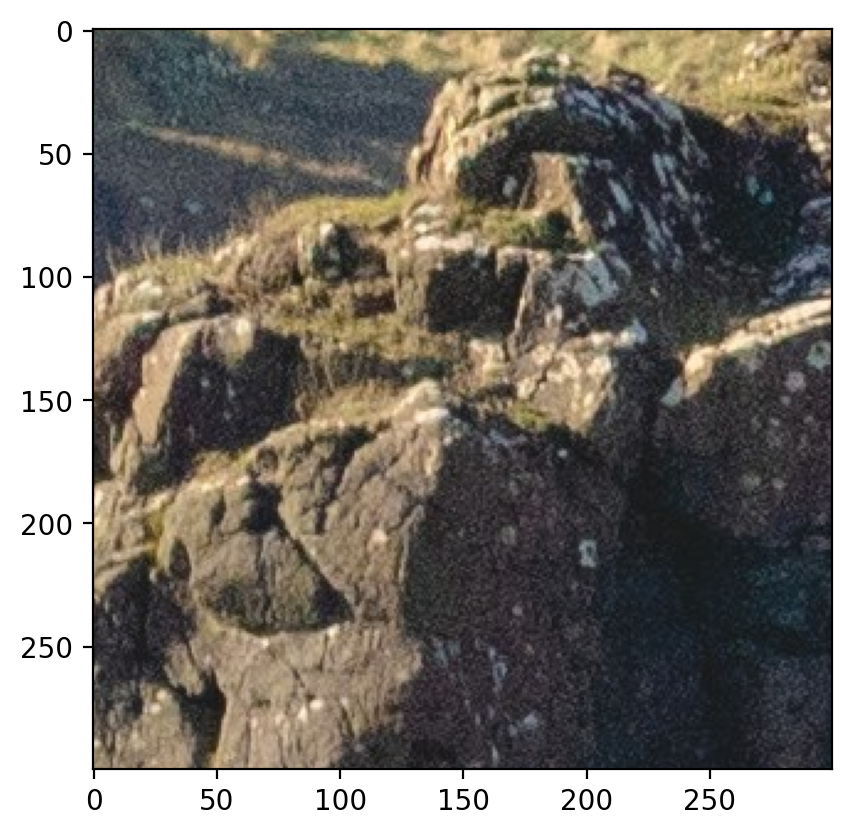

In [8]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 1800, 700, 300, 300)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [9]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [10]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [11]:
img_X, img_Y = create_coordinate_map(crop)

img_X.shape, img_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [12]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(img_X.cpu())

# Scale the X coordinates
img_X_scaled = scaler_X.transform(img_X.cpu())

# Move the scaled X coordinates to the GPU
img_X_scaled = torch.tensor(img_X_scaled).to(device)

# Set to dtype float32
img_X_scaled = img_X_scaled.float()

In [13]:
img_Y_scaled = img_Y

In [14]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)


In [15]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [16]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

train(net, 0.01, img_X_scaled, img_Y, 1000)

Epoch 0 loss: 0.440378
Epoch 100 loss: 0.041087
Epoch 200 loss: 0.032210
Epoch 300 loss: 0.032198
Epoch 400 loss: 0.032198
Epoch 500 loss: 0.032198
Epoch 600 loss: 0.032198
Epoch 700 loss: 0.032198
Epoch 800 loss: 0.032198
Epoch 900 loss: 0.032198


0.03219795227050781

In [17]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        predicted = img_Y.cpu().numpy()
        original = outputs.cpu().numpy()
        rmse = np.sqrt(np.mean((predicted - original) ** 2))
        print(rmse)
        psnr = 20 * np.log10(1.0 / rmse)
        if rmse == 0:
           psnr = float('inf')
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title(f"Reconstructed Image\nRMSE: {rmse:.4f} PSNR: {psnr:.4f}")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

0.17943789


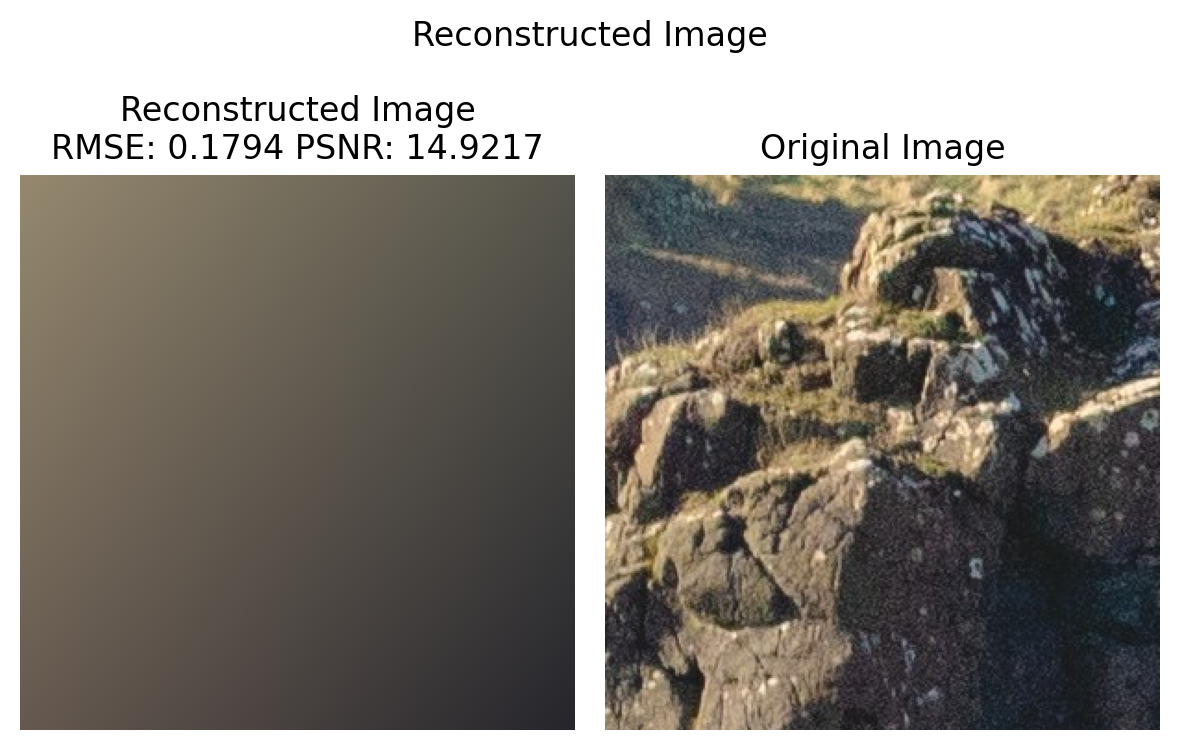

In [18]:
plot_reconstructed_and_original_image(crop, net, img_X_scaled, title="Reconstructed Image")

In [19]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [20]:
X_rff = create_rff_features(img_X_scaled, 20000, 0.008)
X_rff.shape

torch.Size([90000, 20000])

Epoch 0 loss: 0.155022
Epoch 100 loss: 0.015804
Epoch 200 loss: 0.009486
Epoch 300 loss: 0.006489
Epoch 400 loss: 0.004767
Epoch 500 loss: 0.003719
Epoch 600 loss: 0.003062
Epoch 700 loss: 0.002642
Epoch 800 loss: 0.002371
Epoch 900 loss: 0.002196
Epoch 1000 loss: 0.002082
Epoch 1100 loss: 0.002008
Epoch 1200 loss: 0.001960
Epoch 1300 loss: 0.001929
Epoch 1400 loss: 0.001908
Epoch 1500 loss: 0.001894
Epoch 1600 loss: 0.001884
Epoch 1700 loss: 0.001876
Epoch 1800 loss: 0.001871
Epoch 1900 loss: 0.001866
Epoch 2000 loss: 0.001862
Epoch 2100 loss: 0.001859
Epoch 2200 loss: 0.001856
Epoch 2300 loss: 0.001854
Epoch 2400 loss: 0.001852


0.04300852


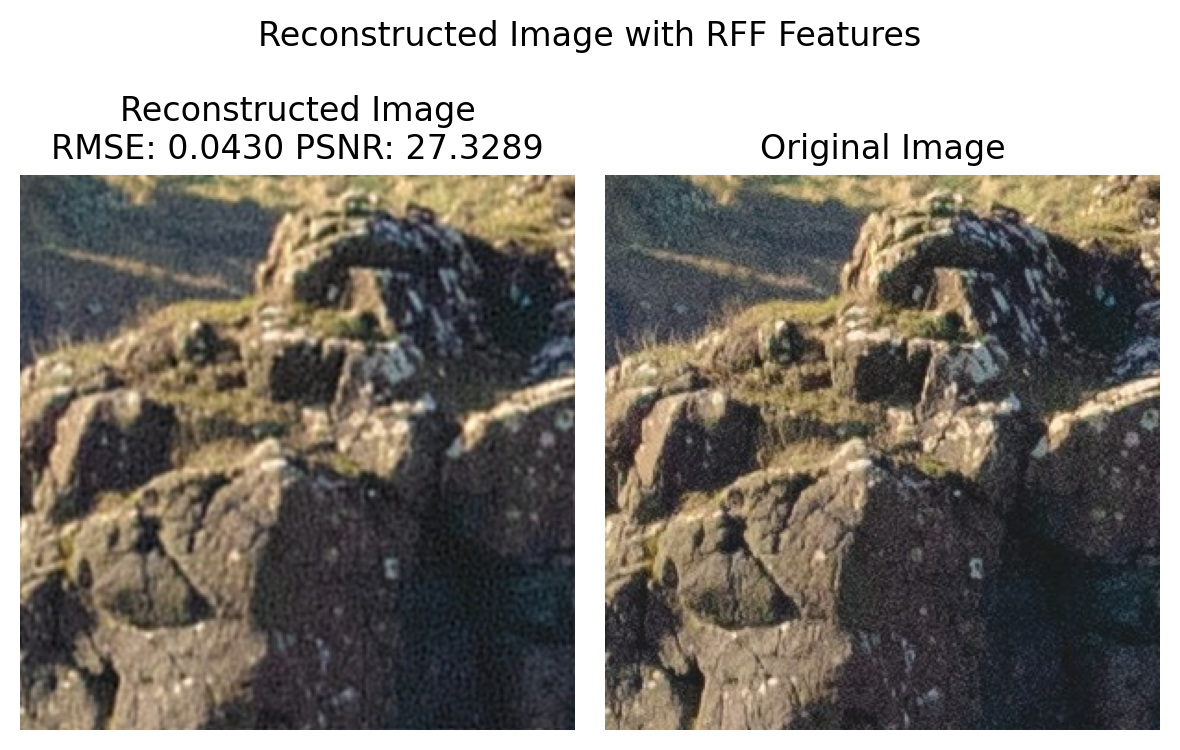

In [21]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff, img_Y, 2500)
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")